In [172]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx

# Aim
Write a simple  algorithm to solve the equation

$du/dt = a*u'' + b*u' + s$

but in graphs!

I will use water as the stuff being transported between nodes. That means that  node $i$ in the graph contains $h_i$ amount of water, and that it only transports water to its  neighbors.

## Ingredients
- A: Adjacency matrix of the graph. A_line is the special case where the graph is a directed straight line with 5 nodes and 4 edges between them, and it is used here to show connection with finite differences. The graph, schematically looks like this:
        1 -> 2 -> 3 -> 4 -> 5

- dem: gives the underlying height of the water canals (above common ref point). This is necessary in practice because water flows along the gradient, and we need to know this for the advection part of the equation
- h: height of water in the canal. More usefully for mass conservation, since canals are thought as being homogeneous, can be thought of as being the mass of water in the canal. h_ini is the initial value.
- L and L_adv: The Laplacian and the modified advection Laplacian (check notes)

In [163]:
def infer_boundary_nodes(directed_adj_matrix):
    """
    Infer what nodes are in the boundaries, i.e., either have no incoming or outgoing neighbors.
    The adj matrix has to be directed

    Parameters
    ----------
    adj_matrix : numpy array
        Adjacency matrix of the canal network graph

    Returns
    -------
    only_incoming : boolean numpy array
        True where nodes have only incoming edges
    only_outgoing : boolean numpy array
        True where nodes have only outgoing edges
    """

    only_outgoing = np.sum(directed_adj_matrix, axis=1) == 0 
    only_incoming = np.sum(directed_adj_matrix, axis=0) == 0
    
    # correction in case a sparse matrix is used:
    only_outgoing = np.ravel(only_outgoing) 
    only_incoming = np.ravel(only_incoming)
   
    return only_outgoing, only_incoming

def laplacian(adj_matrix):
    if np.any(adj_matrix != adj_matrix.T):
        raise ValueError('the matrix must be symmetric, i.e., must be the adj matrix of an undirected graph')
    degree_matrix = np.diag(np.sum(adj_matrix, axis=1))
    laplacian = degree_matrix - adj_matrix
    
    return laplacian

def L_advection(directed_adj_matrix):
    """
    Returns the 'modified advection Laplacian', i.e., the advection operator
    """
    D_out = np.diag(np.sum(directed_adj_matrix, axis=0))
    return  directed_adj_matrix - D_out

def modify_Ladv_with_Neumann_BC(L_adv, L, neumann_bc_bool):
    neumann_nodes = np.where(neumann_bc_bool)[0]
    for nrow in neumann_nodes: # neumann BC
        L_adv[nrow] = -L[nrow] # This is the correct Neumann BC. See notes.
    
    return L_adv

def advection_diffusion_operator(dx, L, L_adv, a, b):
    """
    a and b are the couplings to the diffusion and the advection terms, respectively (see eqn in the intro above)
    """
    L_mix = -a*L/dx**2 + b*L_adv/dx # Note the sign in front of the L term
    return L_mix
    

def forward_Euler_adv_diff_single_step(h, dt, dx, L_mix, source, diri_bc_bool, DIRI_BC, neumann_bc_bool, NEUMANN_BC):

    h = h + dt * L_mix @ h + dt*source
    
    for nrow in np.where(neumann_bc_bool)[0]: # Neumann BC
        h[nrow] = h[nrow] + dt*NEUMANN_BC/dx
    h[diri_bc_bool] = DIRI_BC # Diri BC
    
    return h

def backwards_Euler(h, h_old, dt, dx, a, b, L_mix, source, diri_bc_bool, neumann_bc_bool):
    
    P = np.eye(N=L.shape[0]) - dt*L_mix
    P_inv = np.linalg.inv(P)
    
    h = P_inv @ (h + dt*source)
    
    for nrow in np.where(neumann_bc_bool)[0]: # Neumann BC
        h[nrow] = h[nrow] + dt*NEUMANN_BC/dx
    h[diri_bc_bool] = DIRI_BC # Diri BC
    
    return h

# Initialization

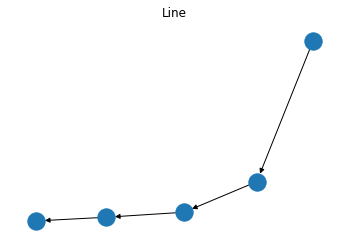

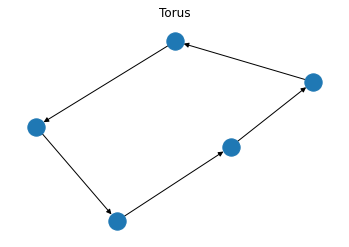

In [181]:
# Define adj matrices for directed and undirected
A_line = np.array([[0,0,0,0,0],
                   [1,0,0,0,0],
                   [0,1,0,0,0],
                   [0,0,1,0,0],
                   [0,0,0,1,0]])
A_line_undirected = A_line + A_line.T

A_torus = np.array([[0,0,0,0,1],
                    [1,0,0,0,0],
                    [0,1,0,0,0],
                    [0,0,1,0,0],
                    [0,0,0,1,0]])
A_torus_undirected = A_torus + A_torus.T


# NetworkX graphs
Gline = nx.DiGraph(A_line)
Gtorus = nx.DiGraph(A_torus)
plt.figure()
plt.title('Line')
nx.draw(Gline)

plt.figure()
plt.title('Torus')
nx.draw(Gtorus)

# Experiments

 ### Diffusion in line

In [230]:
h_ini = [10, 5, 4, 3, 1]
h_dif = h_ini[:]
print("Initial water height: ", h_dif)

a = 1.; b = 0 # Diffusion

# Get BC for nodes
neumann_bc_bool, diri_bc_bool = infer_boundary_nodes(A_line)

# set params
DIRI_BC = 1.
NEUMANN_BC = 0. # If equal to 0., no flux BC
SOURCE = 0.0 # Amount of water entering each node at each timestep

dt=0.1
dx=1.
niter = 100

# Laplacians
L = laplacian(A_line_undirected)
L_adv = L_advection(A_line)
L_adv = modify_Ladv_with_Neumann_BC(L_adv, L, neumann_bc_bool) # Neumann BC do not work out of the box in L_adv, but they do for Lv
L_mix = advection_diffusion_operator(dx, L, L_adv, a, b)

print(f"\n L_mix = \n {L_mix} ")


wl_diffusion = [[] for i in range(niter)]
for t in range(niter):
    wl_diffusion[t] = list(h_dif)
    h_dif = forward_Euler_adv_diff_single_step(h_dif, dt, dx, L_mix, SOURCE, diri_bc_bool, DIRI_BC, neumann_bc_bool, NEUMANN_BC)
    

Initial water height:  [10, 5, 4, 3, 1]

 L_mix = 
 [[-1.  1.  0.  0.  0.]
 [ 1. -2.  1.  0.  0.]
 [ 0.  1. -2.  1.  0.]
 [ 0.  0.  1. -2.  1.]
 [ 0.  0.  0.  1. -1.]] 


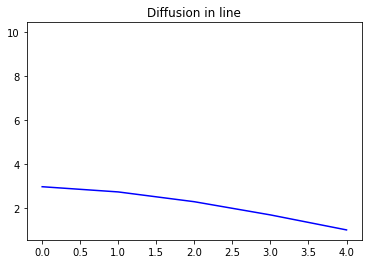

In [212]:
# Plots
%matplotlib inline

import matplotlib.animation as animation
from IPython.display import HTML

fig, ax = plt.subplots()
ax.set_title('Diffusion in line')
x = [i for i in range(len(h))]
hline, = ax.plot(x, wl_diffusion[0], color='blue')

def init():
    hline.set_data([], [])
    return (hline,)

def animate(i):
    x = [0, 1, 2, 3, 4]
    hline.set_data(x, wl_diffusion[i])  # update the data.
    return (hline,)

ani = animation.FuncAnimation(
    fig, animate, init_func=init, interval=10, blit=True, save_count=1, frames=100)


HTML(ani.to_jshtml())

### Advection in torus

In [234]:
h_ini = [50, 1, 1, 1, 1]
h_adv = h_ini[:]
print("Initial water height: ", h_ini)
a = 0.; b = 1 # Advection


niter = 100

# No specified BC in the torus
diri_bc_bool = np.array([False]*5) 
neumann_bc_bool = np.array([False]*5)

# Laplacians
L = laplacian(A_torus_undirected)
L_adv = L_advection(A_torus)
L_adv = modify_Ladv_with_Neumann_BC(L_adv, L, neumann_bc_bool) # Neumann BC do not work out of the box in L_adv, but they do for Lv

L_mix = advection_diffusion_operator(dx, L, L_adv, a, b)
print(f"\n L_mix = \n {L_mix} ")

wl_advection = [[] for i in range(niter)]
for t in range(niter):
    wl_advection[t] = list(h_adv)
    h_adv = forward_Euler_adv_diff_single_step(h_adv, dt, dx, L_mix, SOURCE, diri_bc_bool, DIRI_BC, neumann_bc_bool, NEUMANN_BC)

Initial water height:  [50, 1, 1, 1, 1]

 L_mix = 
 [[-1.  0.  0.  0.  1.]
 [ 1. -1.  0.  0.  0.]
 [ 0.  1. -1.  0.  0.]
 [ 0.  0.  1. -1.  0.]
 [ 0.  0.  0.  1. -1.]] 


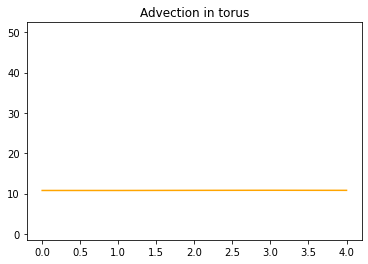

In [235]:
# Plots
%matplotlib inline

import matplotlib.animation as animation
from IPython.display import HTML

fig, ax = plt.subplots()
ax.set_title('Advection in torus')
x = [i for i in range(len(h_adv))]
hline, = ax.plot(x, wl_advection[0], color='orange')

def init():
    hline.set_data([], [])
    return (hline,)

def animate(i):
    x = [0, 1, 2, 3, 4]
    hline.set_data(x, wl_advection[i])  # update the data.
    return (hline,)

ani = animation.FuncAnimation(
    fig, animate, init_func=init, interval=10, blit=True, save_count=1, frames=100)


HTML(ani.to_jshtml())

### Mass is conserved in advection

In [228]:
print("sum of amount of water at each timestep = ", np.array(wl_advection).sum(axis=1))

sum of amount of water at ëach timestep =  [54. 54. 54. 54. 54. 54. 54. 54. 54. 54. 54. 54. 54. 54. 54. 54. 54. 54.
 54. 54. 54. 54. 54. 54. 54. 54. 54. 54. 54. 54. 54. 54. 54. 54. 54. 54.
 54. 54. 54. 54. 54. 54. 54. 54. 54. 54. 54. 54. 54. 54. 54. 54. 54. 54.
 54. 54. 54. 54. 54. 54. 54. 54. 54. 54. 54. 54. 54. 54. 54. 54. 54. 54.
 54. 54. 54. 54. 54. 54. 54. 54. 54. 54. 54. 54. 54. 54. 54. 54. 54. 54.
 54. 54. 54. 54. 54. 54. 54. 54. 54. 54.]
